# Simplex Projection (Univariate)
INPUT: data, E, lib, pred, Tp, tau, data_col\
OUTPUT: graph of predictions vs. actual, Pearson's correlation coefficient ρ

## Defining the Functions:

In [353]:
# Step 1: Find E+1 nearest neighbors to the predictee.

def find_nns(data, E, lib, tau, predictee_index, data_col):
    # Reconstruct your predictee.
    predictee = pd.DataFrame()
    for i in range(0,E,1):
        predictee = pd.concat([data.iloc[[predictee_index + i*tau], [data_col]] , predictee])

    # Empty data frame to store nearest neighbor indexes and distances.
    nns = pd.DataFrame()
    
    # For every point in the library: (1) reconstruct point, (2) calculate distance, (3) add to nns if criteria are met.
    for row in range(lib[0]+tau*(1-E), lib[1]+1, 1):
        
        # Reconstruct attractor point
        point = pd.DataFrame()
        for i in range(0,E,1):
            point = pd.concat([data.iloc[[row + i*tau], [data_col]], point])
        
        # Calculate distance
        distance = math.dist(point.iloc[:,0], predictee.iloc[:,0])
        distance = pd.DataFrame([distance], [row])
        
        # Add distance and index to nns if nns is not of length E+1 yet, or if dist is less than the maximum distance in nns.
        if len(nns) < E+1:
            nns = pd.concat([distance, nns])
            nns = nns.sort_values(by = nns.columns[0], ascending=False)
        elif distance.iloc[0,0] < nns.iloc[0,0]:
            max_idx = nns.idxmax()[0]
            nns.drop(max_idx, inplace = True)
            nns = pd.concat([distance, nns])
            nns = nns.sort_values(by = nns.columns[0], ascending=False)
    nns.columns = ['distances']    
    return(nns)

In [367]:
# Step 2: Project each of the nearest neighbors Tp time steps into the future and calculate their weighted average, giving
#         exponential weight to the distances.

def predict_point(data, nearest_neighbors, Tp, predictee_index, data_col):
    # Calculate a weights vector, giving exponential weight to the distances of each nn from the predictee.
    weights = np.exp(nearest_neighbors) / np.sum(np.exp(nearest_neighbors))
    
    # Get the value of the time series at each nn projected Tp time steps into the future.
    projected_nns = pd.DataFrame()
    for row in range(0,len(nearest_neighbors),1):
        projected_nns = pd.concat([projected_nns, data.iloc[[nearest_neighbors.index[row]+Tp], [data_col]]])
    
    # Calculate the weighted average of the projected nns.
    prediction = np.average(projected_nns, weights = weights)
    
    prediction = pd.DataFrame([prediction], index = [predictee_index + Tp])
    
    return(prediction)

In [430]:
# Step 3: Generate predictions for points in the prediction range using the simplex method.

def simplex(data, E, lib, pred, Tp, tau, data_col):
    
    # Create an empty data frame to store your predictions in.
    predictions = pd.DataFrame()
    
    # For each index in the prediction range, perform the simplex algorithm steps and store the prediction in the predictions
    # data frame.
    for predictee_index in range(pred[0], pred[1], 1):
        nearest_neighbors  = find_nns(data,E, lib, tau, predictee_index, data_col)
        prediction         = predict_point(data, nearest_neighbors, Tp, predictee_index, data_col)
        predictions        = pd.concat([predictions, prediction])
    
    return(predictions)

In [431]:
# Step 4: Calculate rho between predicted and actual, and graph the results.

def plot_results(predictions, data, pred, data_col):
    # Create a dataframe to store the predicted and actual values. 
    pred_data = data.iloc[pred[0]+1:pred[1],[data_col]]
    predictions2 = predictions[:-1]
    prediction_vs_actual = pd.concat([predictions2, pred_data], axis = 1)
    prediction_vs_actual.columns = ['prediction', 'actual'] 

    # Calculate Pearson's correlation coefficient between the prediction and actual columns of the dataframe.
    rho = prediction_vs_actual.corr()
    rho = rho.loc['prediction']['actual']

    # Plot the results
    title = 'ρ = ' + str(rho)
    prediction_vs_actual.plot(y=['prediction', 'actual'], use_index = True, title = title)

## Running the Code:

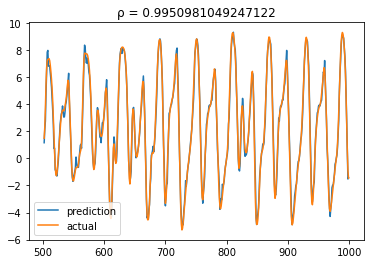

In [429]:
import numpy as np
import pandas as pd
import math

data = pd.read_csv('../../research/jpyEDM-master/data/Lorenz5d.csv')
E = 2
tau = -1
Tp = 1
data_col = 1
lib = [0,500]
pred = [501,1000]

predictions = simplex(data, E, lib, pred, Tp, tau, data_col)
plot_results(predictions, data, pred, data_col)